In [12]:
# This study classifying pottery shapes to assist archaeologists
# analizing from data collected in data_dressel.csv
# We want to identify which measurable attributes (diameter, height, etc.) 
# are most useful for identifying the shape of a pottery fragment.

# ---------------------------------------------------
# GATHER  | Imports & constants
# ---------------------------------------------------
from __future__ import annotations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor, plot_tree
# Constants
RANDOM_STATE = 42
TEST_SIZE = 0.20
MAX_DEPTH = 3
CSV_PATH = "data_dressel.csv" 
#considering crucial attributes in pottery fragments for shape classification,
#considering diameter, height, type, and protruding rim features.
#FEATURE_NAMES = ["exterior_diam", "rim_h", "rim_w", "chronology", "site"]
FEATURE_NAMES = ['exterior_diam','inside_diam','rim_h','rim_w','rim_inside_h','rim_w_2','protruding_rim']
TARGET_NAME = "shape_w"




In [13]:

# ---------------------------------------------------
# CLEAN  | Utilities
# ---------------------------------------------------
#Normalize column names by: 
#- removing leading/trailing whitespaces
#- converting everything to lowercase
#- removing backslashes ("\")
#- replacing forward slashes ("/") with underscores ("_")
#This ensures the DataFrame has clean, consistent, machine‑friendly column names.    
def normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    normalized = [
        #c.strip() to remove leading and trailing whitespace
        #.lower() to Convert to lowercase for consistency
        #.replace("\\", "") to remove backslashes (escape characters)
        #.replace("/", "_") to replace slashes with underscores to avoid invalid Python identifiers
        c.strip().lower().replace("\\", "").replace("/", "_")
        # Apply transformation to every column name
        for c in df.columns
    ]
    # Assign the cleaned names back to the DataFrame
    df.columns = normalized
    # Return the modified DataFrame so it can be used downstream
    return df

#Encode all columns that contain string (object) values using Label Encoding
#because of technical compatibility: decision tree models (and most ML algorithms) require numeric input.
#This function detects any column with dtype 'object' and automatically
#converts its categories (A, B, C, …) into integer codes (0, 1, 2, …).
def encode_columns(df: pd.DataFrame) -> pd.DataFrame:
    # Loop through every column in the DataFrame
    for col in df.columns:
        # Check if the column contains object type (usually strings)
        if df[col].dtype == 'object':
            # Convert to string (to avoid issues with mixed types),
            # then apply LabelEncoder to transform categories → integers.
            df[col] = LabelEncoder().fit_transform(df[col].astype(str))
    #Return the transformed DataFrame for further processing
    return df

# Remove rows where either:
#    - the 'chronology' feature is NaN, or
#    - the target value is NaN.
#    Returns:
#        - the filtered feature DataFrame (X)
#        - the filtered target Series (y)
#        - the boolean mask used for filtering (useful for plots)
# because The model cannot learn from a row where either feature 
# or target is missing and common ML algorithms in Python do not accept missing values 
# as input, for example: Linear regression (sklearn.linear_model.LinearRegression)
def filter_non_null(
    features_df: pd.DataFrame, target_series: pd.Series
) -> tuple[pd.DataFrame, pd.Series, pd.Series]:
    # Build a boolean mask that is True only for rows where:
    # - 'chronology' is NOT NaN
    # - the target value is NOT NaN
    non_null_mask = features_df["chronology"].notna() & target_series.notna()
    return features_df[non_null_mask], target_series[non_null_mask], non_null_mask


In [14]:
# ---------------------------------------------------
# MODEL  | Training & evaluation
# ---------------------------------------------------
#Fit and return a DecisionTreeRegressor.
def train_decision_tree(X_train: pd.DataFrame, y_train: pd.Series, max_depth: int = MAX_DEPTH) -> DecisionTreeRegressor:   
    # Create a DecisionTreeRegressor instance.
    # - random_state ensures reproducible results.
    # - max_depth limits how deep the tree can grow,
    # max_depth controls how complex a decision tree can grow, 
    # and balances underfitting versus overfitting (too deep)
    #   For example:
    # Depth 3 → readable
    # Depth 10 → impossible to interpret manually
    # Depth 20+ → meaningless to inspect
    regressor = DecisionTreeRegressor(random_state=RANDOM_STATE, max_depth=max_depth)
    # Train (fit) the decision tree using the training
    # features X_train and training labels y_train.
    regressor.fit(X_train, y_train)
    # Return the trained model so it can be used for
    # prediction or evaluation.
    return regressor

# Return MAE, MSE, RMSE, and R2 on the test set.
def evaluate_model(
    regressor: DecisionTreeRegressor, X_test: pd.DataFrame, y_test: pd.Series
) -> float:
    # Predict on the test features
    y_pred = regressor.predict(X_test)
    # Compute metrics
    mae = mean_absolute_error(y_test, y_pred)
    # Compute the Mean Squared Error (MSE) between the true values (y_test)
    # and the predicted values (y_pred).
    # MSE measures the average squared difference; lower is better.
    mse_value = mean_squared_error(y_test, y_pred)
    rmse = float(np.sqrt(mse_value))
    r2 = r2_score(y_test, y_pred)
    
    # Return all metrics in a dict
    return pd.Series({"MAE": mae, "MSE": mse_value, "RMSE": rmse, "R2": r2})

# Return feature importances as a Series indexed by feature name.
def get_feature_importances(    
    # regressor.feature_importances_` is an array where each value corresponds
    # to the importance of a feature used by the decision tree.
    # ->pd-Series wrap these values into a pandas Series easier to read
    regressor: DecisionTreeRegressor, feature_names: list[str]
) -> pd.Series:
    #return panda series
    return pd.Series(regressor.feature_importances_, index=feature_names)

In [3]:
# ---------------------------------------------------
# VISUALIZE  | Plots
# ---------------------------------------------------
def plot_feature_importances(feature_importances: pd.Series) -> None:
    """Horizontal bar chart of feature importances."""
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importances.index, feature_importances.values, color="#4C78A8")
    plt.title("Feature Importances (Decision Tree)")
    plt.xlabel("Gini importance")
    plt.tight_layout()
    plt.show()

def plot_decision_tree_diagram(
    regressor: DecisionTreeRegressor, feature_names: list[str], target_name: str
) -> None:
    """Plot the fitted decision tree."""
    plt.figure(figsize=(22, 12))
    plot_tree(
        regressor,
        feature_names=feature_names,
        filled=True,
        rounded=True,
        fontsize=10,
    )
    plt.title(f"Decision Tree to predict '{target_name}'")
    plt.tight_layout()
    plt.show()

def plot_target_histogram(data_df: pd.DataFrame, target_name: str) -> None:
    """Histogram of the target variable."""
    plt.figure(figsize=(8, 5))
    plt.hist(data_df[target_name], bins=20, color="#4C78A8", edgecolor="white")
    plt.title(f"'{target_name}' distribution")
    plt.xlabel(target_name)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

def plot_feature_boxplots(data_df: pd.DataFrame, feature_names: list[str]) -> None:
    """Boxplots for numeric feature columns."""
    plt.figure(figsize=(10, 6))
    data_df[feature_names].boxplot()
    plt.title("Boxplot of numeric variables")
    plt.ylabel("Values")
    plt.tight_layout()
    plt.show()

def plot_exterior_diam_splits(
    regressor: DecisionTreeRegressor,
    data_df: pd.DataFrame,
    non_null_mask: pd.Series,
    feature_name: str = "exterior_diam",
    target_name: str = TARGET_NAME,
) -> None:
    """
    Plot the exterior_diam values vs target (factorized) and show the model's split thresholds.
    """
    # Extract thresholds from the fitted tree
    thresholds = []
    tree_structure = regressor.tree_
    for node_idx in range(tree_structure.node_count):
        threshold = tree_structure.threshold[node_idx]
        if threshold != -2:  # -2 indicates a leaf
            thresholds.append(threshold)
    thresholds = sorted(set(round(t, 3) for t in thresholds))
    x_feature = data_df[[feature_name]].astype(float)
    y_target = data_df[target_name].astype(str)
    # Factorize target for scatter visualization
    y_numeric = (
        y_target.astype(int)
        if y_target.str.isnumeric().all()
        else pd.factorize(y_target)[0]
    )
    plt.figure(figsize=(10, 2.8))
    plt.scatter(x_feature[feature_name][non_null_mask], y_numeric[non_null_mask], s=14, alpha=0.7)
    for thr in thresholds:
        plt.axvline(thr, color="crimson", linestyle="--", linewidth=1)
    plt.title(f"Splits on {feature_name}")
    plt.xlabel(feature_name)
    plt.ylabel(target_name)
    plt.tight_layout()
    plt.show()


In [15]:

# ---------------------------------------------------
# GATHER  | Load libraries & data
# ---------------------------------------------------
data_df = pd.read_csv(CSV_PATH)


In [16]:
# ---------------------------------------------------
# ASSESS  
# ---------------------------------------------------
  # Quick EDA (optional interactive use)
data_df.head()


,number,excavation,type,chronology,exterior_diam,inside_diam,rim_h,rim_w,shape_w,rim_inside_h,rim_w_2,protruding_rim,site
0,1,delicias,Dressel B,A,150,120,44,24,11,40,9,40,delicias
1,2,delicias,Dressel B,A,140,102,46,30,7,45,16,39,delicias
2,3,delicias,Dressel B,A,150,110,45,25,11,41,22,36,delicias
3,4,delicias,Dressel E,C,180,90,35,40,14,28,35,9,delicias
4,5,delicias,Dressel B,A,130,86,44,27,12,36,17,32,delicias


In [17]:
data_df.describe()
# rim_w – rim width (external): the single strongest predictor.
# rim_w_2 – the second rim width measure: complements rim_w and consistently ranks high.
# exterior_diam – mouth/external diameter: discriminates broader vs. narrower rims across types.
# rim_h – rim (lip) height: helps separate high‑lip vs. low‑lip variants.
# protruding_rim – degree of rim projection: captures lip form/overhang.
# shape_w – “shape width” around the rim: adds secondary separation.
# inside_diam – internal diameter: useful but less discriminative than the external measures.
# rim_inside_h – inner rim height: the weakest among the tested metrics.


,number,exterior_diam,inside_diam,rim_h,rim_w,shape_w,rim_inside_h,rim_w_2,protruding_rim
count,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000
mean,50.548936,166.889362,94.474468,35.391489,36.293617,9.512766,28.380851,30.348936,18.889362
std,31.830520,12.840189,10.050108,3.583296,4.758895,1.358401,3.564462,5.376006,6.608815
min,1.000000,120.000000,70.000000,25.000000,15.000000,5.000000,18.000000,7.000000,5.000000
25%,24.000000,160.000000,90.000000,34.000000,34.000000,9.000000,26.000000,28.000000,14.000000
50%,47.500000,170.000000,90.000000,35.000000,37.000000,10.000000,28.000000,31.000000,18.000000
75%,74.000000,175.000000,100.000000,37.000000,40.000000,10.000000,30.000000,34.000000,23.000000
max,128.000000,210.000000,140.000000,56.000000,48.000000,14.000000,45.000000,44.000000,42.000000


In [18]:
data_df.isna().sum()

number            0
excavation        0
type              0
chronology        8
exterior_diam     0
inside_diam       0
rim_h             0
rim_w             0
shape_w           0
rim_inside_h      0
rim_w_2           0
protruding_rim    0
site              0
dtype: int64

In [19]:
# ---------------------------------------------------
# CLEAN  | Normalize column names, encode categories, remove nulls
# ---------------------------------------------------
data_df = normalize_columns(data_df)
data_df = encode_columns(data_df)
# Define features & target
features_df = data_df[FEATURE_NAMES]
target_series = data_df[TARGET_NAME]
# Remove nulls w.r.t. 'chronology' and target
#features_df, target_series, non_null_mask = filter_non_null(features_df, target_series)


In [20]:
# ---------------------------------------------------
# ANALYZE  | Split, quick metrics scaffolding
# ---------------------------------------------------
X_train_df, X_test_df, y_train_series, y_test_series = train_test_split(features_df, target_series, test_size=TEST_SIZE, random_state=RANDOM_STATE)


In [21]:
# ---------------------------------------------------
# MODEL   | Fit model, predict, evaluate
# ---------------------------------------------------
tree_regressor = train_decision_tree(X_train_df, y_train_series, max_depth=MAX_DEPTH)


In [22]:
# Evaluate
#mse_value = evaluate_model(tree_regressor, X_test_df, y_test_series)
metrics = evaluate_model(tree_regressor, X_test_df, y_test_series)

In [23]:

# ---------------------------------------------------
# VISUALIZE  | Feature importance, tree, distributions, boxplots, splits
# ---------------------------------------------------
print("\n Metrics caluclated:")
print(metrics.round(4))


 Metrics caluclated:
MAE     1.1698
MSE     2.2344
RMSE    1.4948
R2      0.0145
dtype: float64


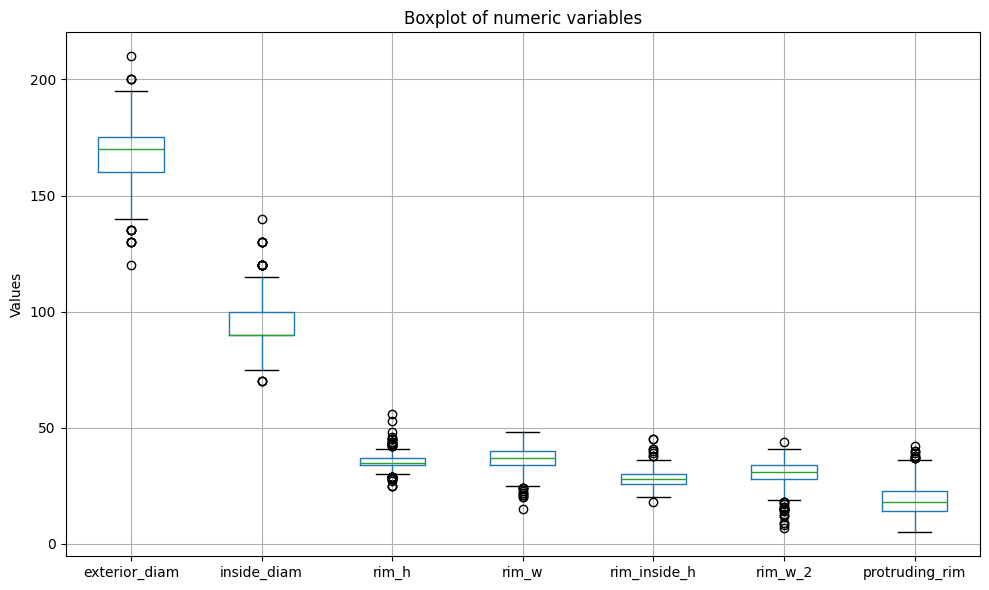

In [24]:
#Plot distribution for numeric values
plot_feature_boxplots(data_df, FEATURE_NAMES)

In [25]:
# Feature importances
feature_importances = get_feature_importances(tree_regressor, FEATURE_NAMES)
print("\nFeature Importances:")
print(feature_importances.sort_values(ascending=False))


Feature Importances:
protruding_rim    0.493130
rim_h             0.285772
rim_w_2           0.213428
rim_inside_h      0.007670
exterior_diam     0.000000
inside_diam       0.000000
rim_w             0.000000
dtype: float64


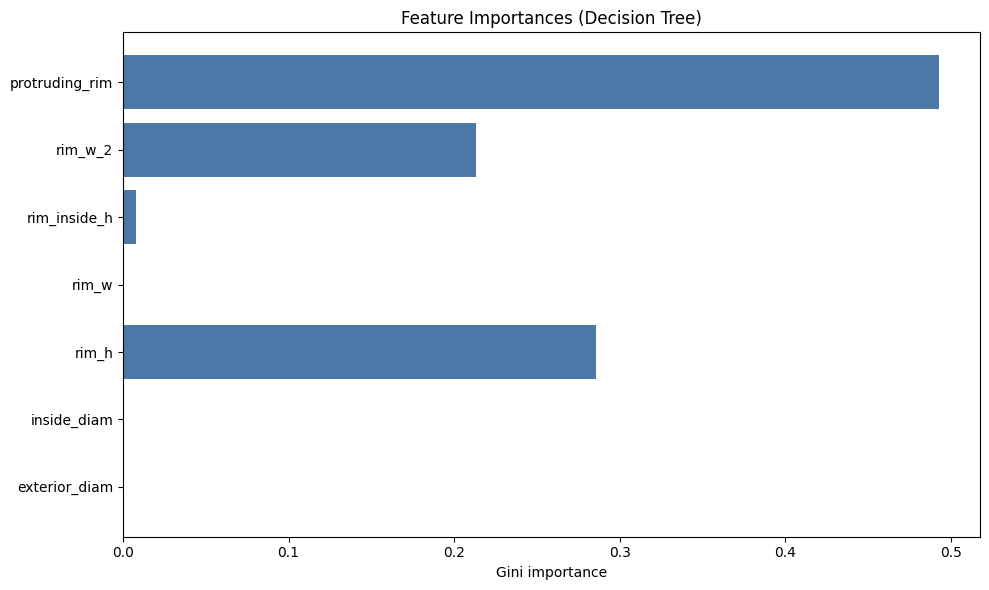


This answer to the original question:
What is the most important factor in predicting pottery shape?

Comment:

 protruding_rim = 0.493 means that this feature dominates the prediction of shape_w.
 Rim height is the second strongest driver. It captures much of the vertical lip profile that relates to shape_w.
 Very small contribution by rim_w_2 and rim_inside_h.
 exterior_diam, inside_diam, rim_w  have 0 importance and means the tree never split on them.


In [33]:
plot_feature_importances(feature_importances)
print("\nThis answer to the original question:\nWhat is the most important factor in predicting pottery shape?")
print("\nComment:")
print("\n protruding_rim = 0.493 means that this feature dominates the prediction of shape_w.\n Rim height is the second strongest driver. It captures much of the vertical lip profile that relates to shape_w.\n Very small contribution by rim_w_2 and rim_inside_h.\n exterior_diam, inside_diam, rim_w  have 0 importance and means the tree never split on them.") 

In [26]:
print("\nEvaluate how ""site"" and ""chronology"" impact on shape_w prediction:")
site_means = data_df.groupby('site')['shape_w'].mean().sort_values()
chron_means = data_df.groupby('chronology')['shape_w'].mean().sort_values()
site_means



Evaluate how site and chronology impact on shape_w prediction:


site
1     8.859375
2     9.405405
0     9.584270
3     9.869048
4    10.534483
Name: shape_w, dtype: float64

In [27]:
print("\nInterpretation:")
print("\n site 4 is Villaseca and fragments tend to have the highest shape_w")
print("\n site 1 is Delicias and fragments have the lowest shape_w")
print("\n Differences between sites are small compared to variation explained by geometric features like:rim protrusion, rim height,rim width")



Interpretation:

 site 4 is Villaseca and fragments tend to have the highest shape_w

 site 1 is Delicias and fragments have the lowest shape_w

 Differences between sites are small compared to variation explained by geometric features like:rim protrusion, rim height,rim width


In [28]:
chron_means

chronology
4    9.000000
3    9.421622
2    9.449495
0    9.916667
1    9.945455
Name: shape_w, dtype: float64

In [29]:
print("\nInterpretation:")
print("\n Earlier forms (period 1 is A-B and period 0 is A; those show slightly larger shape_w.")
print("\n period 3 is C show slightly smaller shape_w.")
print("\nMost of the shape variation is intra‑type, not strictly chronological.")


Interpretation:

 Earlier forms (period 1 is A-B and period 0 is A; those show slightly larger shape_w.

 period 3 is C show slightly smaller shape_w.

Most of the shape variation is intra‑type, not strictly chronological.


In [30]:
print("\Comment:")
print("\n chronology and site influence shape_w moderately, the effect size is much smaller than geometric predictors (like rim protrusion or rim height).")
print("\n rim geometry explains almost everything while site andchronology introduce only subtle background variation")


\Comment:

 chronology and site influence shape_w moderately, the effect size is much smaller than geometric predictors (like rim protrusion or rim height).

 rim geometry explains almost everything while site andchronology introduce only subtle background variation


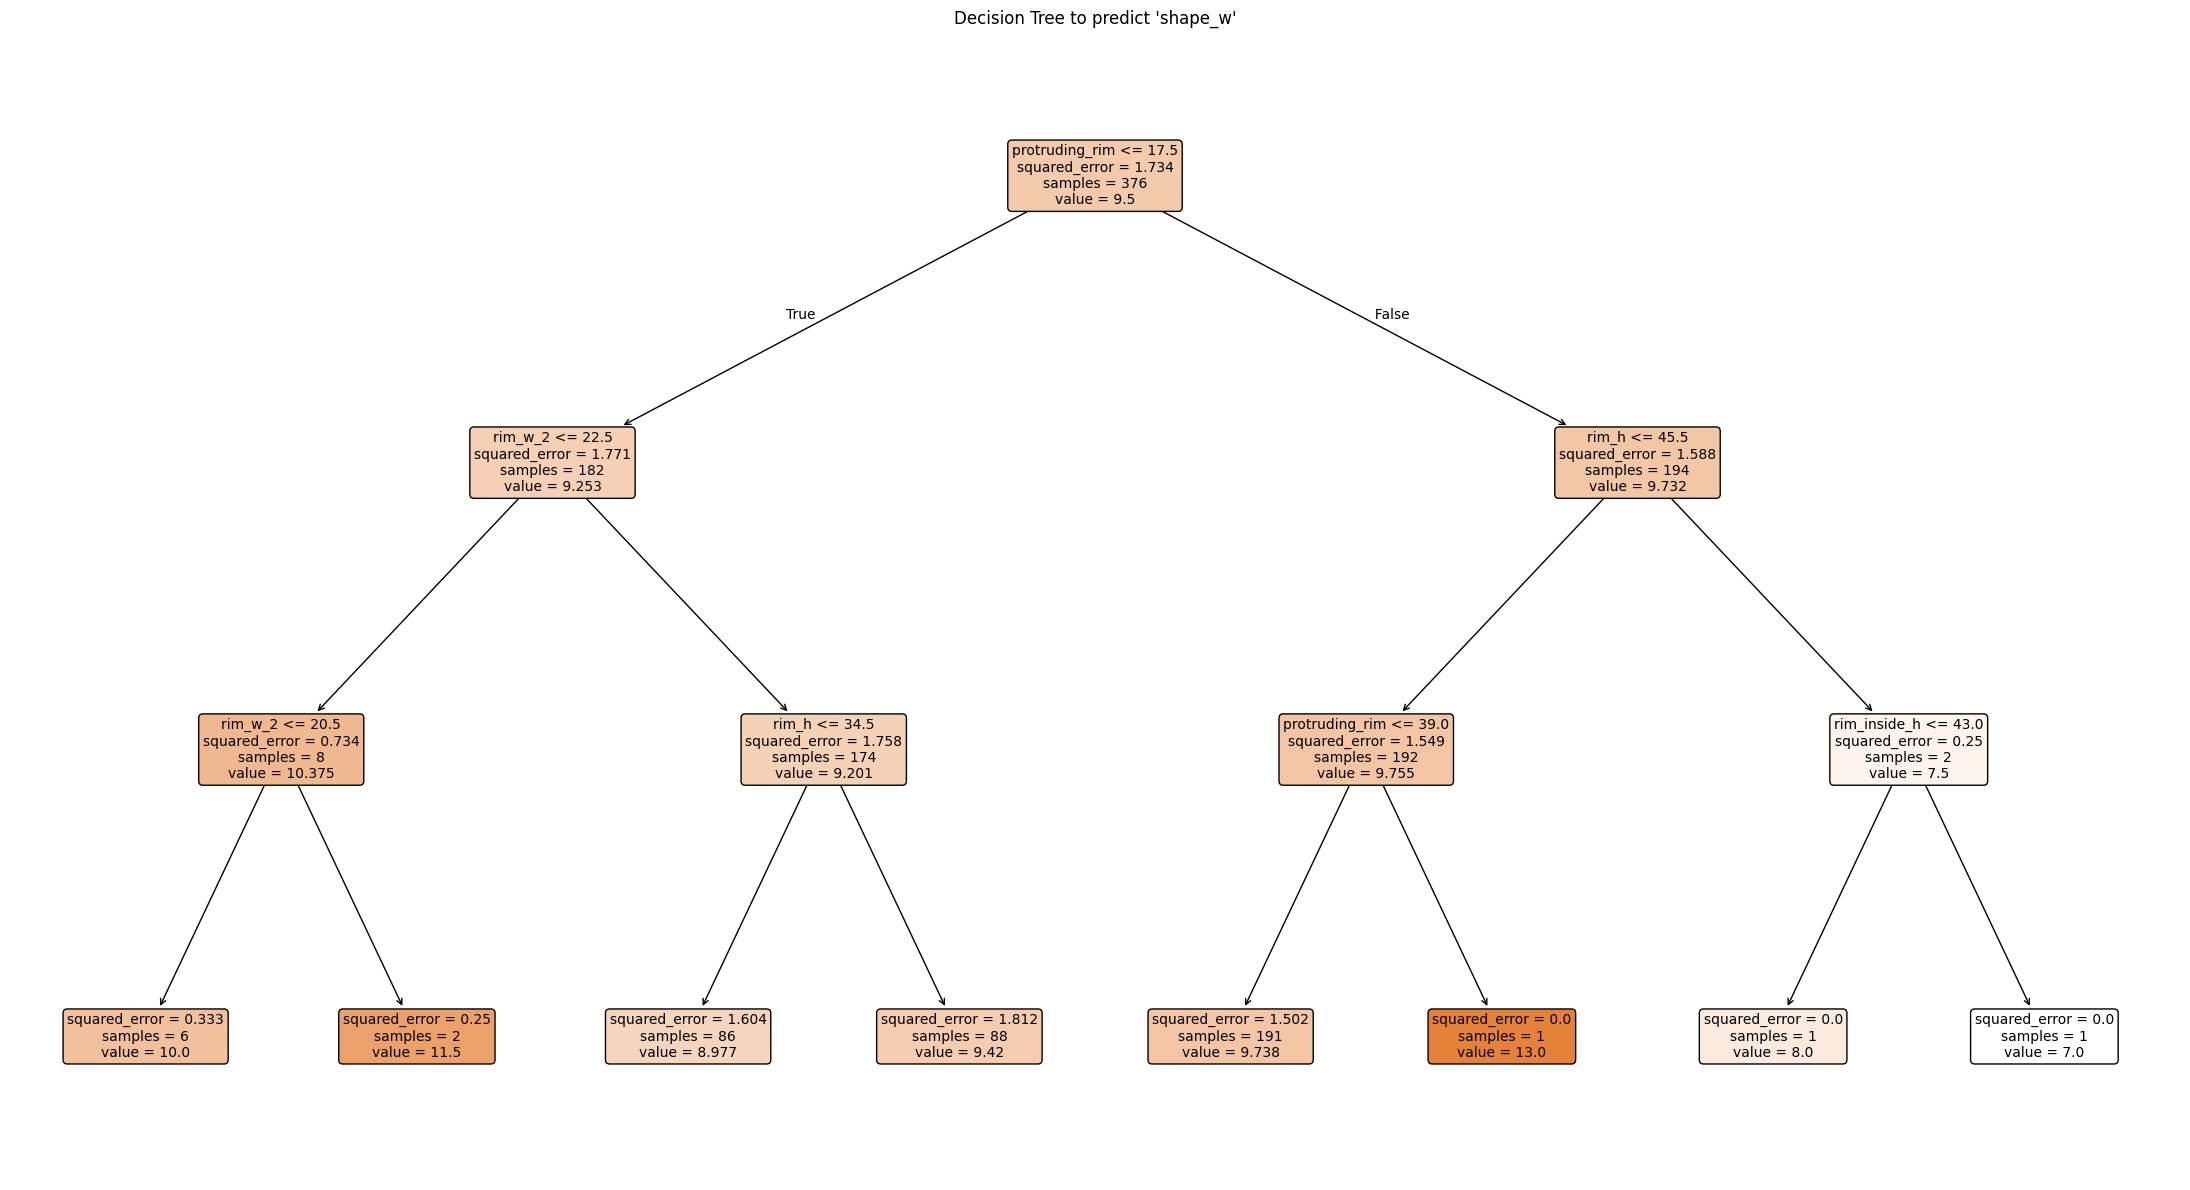

In [32]:
#plot decision tree
plot_decision_tree_diagram(tree_regressor, FEATURE_NAMES, TARGET_NAME)

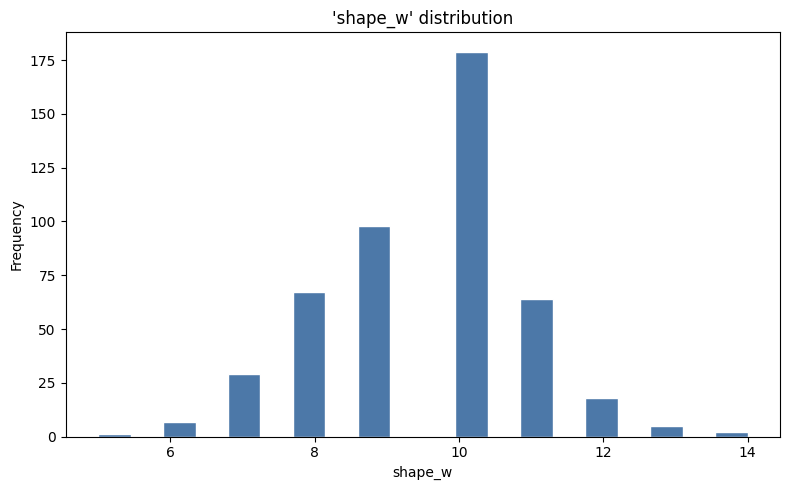

In [33]:
#plot histogram for target frequency values
plot_target_histogram(data_df, TARGET_NAME)